In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')
sns.set_style('darkgrid')

In [3]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 15)

In [4]:
prices = pd.read_csv('spy_top200_021221.csv', index_col=0)

In [5]:
prices = prices.loc['2017-01-01':'2019-12-31'].dropna(axis=1)
prices.drop(['SPY'], axis=1, inplace=True)
prices

,AAPL,MSFT,AMZN,TSLA,GOOGL,NVDA,GOOG,...,AZO,ROK,PH,ROST,MPC,DD,PAYX
2017-01-03,27.329189,58.184801,753.67,43.398,808.01,25.171238,786.14,...,791.46,125.769368,131.095973,62.784294,43.829719,139.688077,52.410622
2017-01-04,27.298601,57.924466,757.18,45.398,807.77,25.758510,786.90,...,793.04,125.242833,131.178741,63.683810,42.430282,140.750777,52.608042
2017-01-05,27.437423,57.924466,780.45,45.350,813.02,25.104615,794.02,...,792.00,125.043112,130.010787,62.860849,42.272949,140.067613,52.230370
2017-01-06,27.743303,58.426540,795.99,45.802,825.21,25.440199,806.15,...,792.91,125.742134,130.121145,62.497215,41.709861,139.251612,52.590875
2017-01-09,27.997418,58.240587,796.92,46.256,827.18,26.471625,806.65,...,790.34,125.560570,129.468194,62.631185,40.956318,139.896822,52.376288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,70.026516,154.435994,1789.21,85.050,1344.43,59.504081,1343.56,...,1219.31,196.050527,200.199134,113.863486,55.371684,61.375719,79.887299
2019-12-26,71.415863,155.701863,1868.77,86.188,1362.47,59.646220,1360.40,...,1210.72,197.384336,201.353159,114.051412,54.917595,61.327604,79.943923
2019-12-27,71.388766,155.986438,1869.80,86.076,1354.64,59.067688,1351.89,...,1202.59,196.176176,200.742205,113.705232,54.835858,61.327604,80.330855
2019-12-30,71.812467,154.642066,1846.89,82.940,1339.71,57.933065,1336.14,...,1183.25,196.137514,199.539691,115.228423,54.191051,59.941887,80.113796


In [6]:
returns = prices.pct_change().dropna()
returns_train = returns.loc[:'2019-06-30']
returns_test = returns.loc['2019-07-01':]
prices_train = prices.loc[returns_train.index]
prices_test = prices.loc[returns_test.index]

In [7]:
len(returns_train.index)

625

In [8]:
# length of training period must be even
prices_train = prices_train.iloc[1:]
returns_train = returns_train.iloc[1:]
len(prices_train)

624

# Backtests

In [9]:
pairs_dfs = {}
pair_rets = {}
traded_pairs = {}
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])

In [10]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [11]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

# Simple Distance

In [12]:
# transform prices to cumulative returns
cumret = (1 + returns).cumprod()
cumret = cumret / cumret.iloc[0]
cumret_train = cumret.loc[returns_train.index]
cumret_test = cumret.loc[returns_test.index]

In [13]:
pairs_df = pd.DataFrame(columns=['Spread SSD', 'Spread SD'])
stocks = cumret.columns

for s1 in tqdm(stocks):
    for s2 in stocks:
        if (s1!=s2) and (f'{s2}-{s1}' not in pairs_df.index):
            spread = cumret_train[s1] - cumret_train[s2]
            ssd = np.sum(spread**2) / len(spread)
            sd = spread.std()
            pairs_df.loc[f'{s1}-{s2}', ['Spread SSD', 'Spread SD']] = ssd, sd

100%|██████████| 196/196 [00:34<00:00,  5.66it/s]


In [14]:
pairs_df.sort_values(by='Spread SSD')

,Spread SSD,Spread SD
GOOGL-GOOG,0.000505,0.011006
JPM-BAC,0.001654,0.039069
CB-CL,0.001697,0.040849
SPGI-MCO,0.00184,0.041133
AXP-FIS,0.002369,0.047839
...,...,...
ALGN-DD,3.083529,0.917861
T-ALGN,3.126138,0.874117
AIG-ALGN,3.194067,0.883588
ALGN-SLB,3.566792,0.894775


In [15]:
# calculate in-sample Sharpe ratios for top N pairs
N = 200
insample_sharpe = pd.DataFrame(index=pairs_df.sort_values(by='Spread SSD').index[:N], columns=['Sharpe'])

for pair in insample_sharpe.index:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    spread = cumret_train[s1] - cumret_train[s2]
    sd = pairs_df.loc[pair]['Spread SD'] # historical SD
    
    positions = pd.DataFrame(index=spread.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1)
    insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)

/tmp/ipykernel_565082/2236677161.py:35: RuntimeWarning: invalid value encountered in double_scalars
  insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)


In [16]:
cond1 = insample_sharpe['Sharpe'] > 1
insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False)

,Sharpe
HD-BDX,2.648969
AXP-FIS,2.271201
UPS-GILD,2.111572
NKE-FISV,1.997082
ECL-TT,1.981609
...,...
WFC-PRU,1.032308
WM-TT,1.029448
T-AIG,1.013732
PLD-ICE,1.003485


In [17]:
potential_pairs = insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False).index

In [18]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

for pair in potential_pairs:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    spread = cumret_test[s1] - cumret_test[s2]
    sd = pairs_df.loc[pair]['Spread SD'] # historical SD
    
    positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
    
    pair_ret[pair] = ret

In [19]:
# cumulative returns of individual pairs
pair_cumret = (1 + pair_ret).cumprod()
pair_cumret

,HD-BDX,AXP-FIS,UPS-GILD,NKE-FISV,ECL-TT,SPGI-MCO,GS-BMY,...,MDLZ-SO,JPM-LMT,WFC-PRU,WM-TT,T-AIG,PLD-ICE,CB-D
2019-07-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000548,1.000000,1.000000,1.000000,1.000000
2019-07-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.990773,0.995093,1.000000,1.000000,1.000000,1.000000
2019-07-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.997888,0.994572,1.000000,1.000000,1.000000,1.000000
2019-07-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.994433,0.997998,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.069143,0.989770,0.957342,1.116515,1.018158,1.149775,1.180951,...,0.945528,1.115730,1.135792,1.193071,0.887176,1.029323,1.124593
2019-12-26,1.060779,0.989200,0.946863,1.128614,1.024539,1.149775,1.172670,...,0.942522,1.115730,1.135792,1.205510,0.877049,1.030472,1.124593
2019-12-27,1.071868,0.979976,0.941383,1.128039,1.021156,1.149775,1.166581,...,0.945584,1.115730,1.135792,1.208840,0.883054,1.028884,1.124593
2019-12-30,1.075676,0.981073,0.946610,1.134999,1.031934,1.149775,1.169688,...,0.947458,1.115730,1.135792,1.220703,0.886344,1.020484,1.124593


In [20]:
# fraction of pairs with positive returns
(pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

0.6310679611650486

In [21]:
# fraction of pairs with no positions
(pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

0.06796116504854369

In [22]:
total_ret = pair_ret.sum(axis=1) / len(pair_ret.columns)

In [23]:
total_cumret = (1 + total_ret).cumprod()
total_cumret

2019-07-01    1.000000
2019-07-02    1.000955
2019-07-03    1.000882
2019-07-05    1.001229
2019-07-08    1.000175
                ...   
2019-12-24    1.056932
2019-12-26    1.056025
2019-12-27    1.054479
2019-12-30    1.056207
2019-12-31    1.056689
Length: 128, dtype: float64

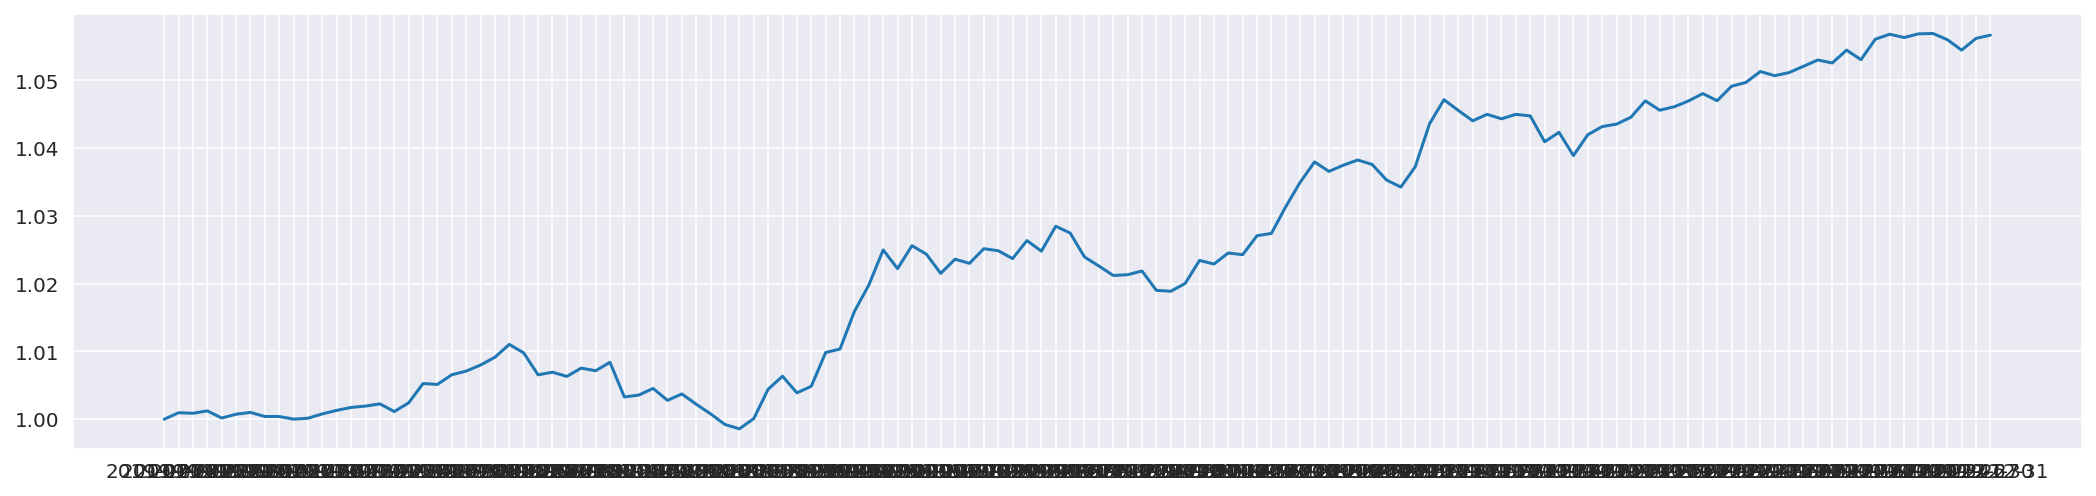

In [24]:
plt.figure(figsize=(18,4))
plt.plot(total_cumret)

In [25]:
results_df.loc['Simple Distance'] = calculate_metrics(total_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.01232,23.0


In [26]:
# save returns and pairs df
pairs_dfs['dist_nf'] = pairs_df
pair_rets['dist_nf'] = pair_ret
traded_pairs['dist_nf'] = pair_ret.columns

### Limit to top 10 pairs consisting of different stocks

In [27]:
selected_pairs = []
selected_stocks = []

# process opening signals day by day
for i in range(len(pair_cumret.index)):
    idx = pair_cumret.iloc[i][pair_cumret.iloc[i]!=1].index # pairs opened on day i
    # sort by Sharpe ratio and start selecting
    for pair in insample_sharpe.loc[idx].sort_values(by='Sharpe', ascending=False).index:
        s1,s2 = parse_pair(pair)
        if (s1 not in selected_stocks) and (s2 not in selected_stocks):
            selected_pairs.append(pair)
            selected_stocks.extend([s1,s2])
        if len(selected_pairs)==10:
            break
    if len(selected_pairs)==10:
            break

In [28]:
insample_sharpe.loc[selected_pairs]

,Sharpe
GM-BK,1.888911
CCI-AON,1.626645
GOOGL-HD,1.482305
MDLZ-PSA,1.370313
T-JCI,1.313382
SNPS-ROP,1.281478
MS-C,1.231234
ECL-EXC,1.218457
FIS-APH,1.215998
GOOG-BDX,1.131152


In [29]:
top_ret = pair_ret[selected_pairs].sum(axis=1) / len(selected_pairs)
top_cumret = (1 + top_ret).cumprod()

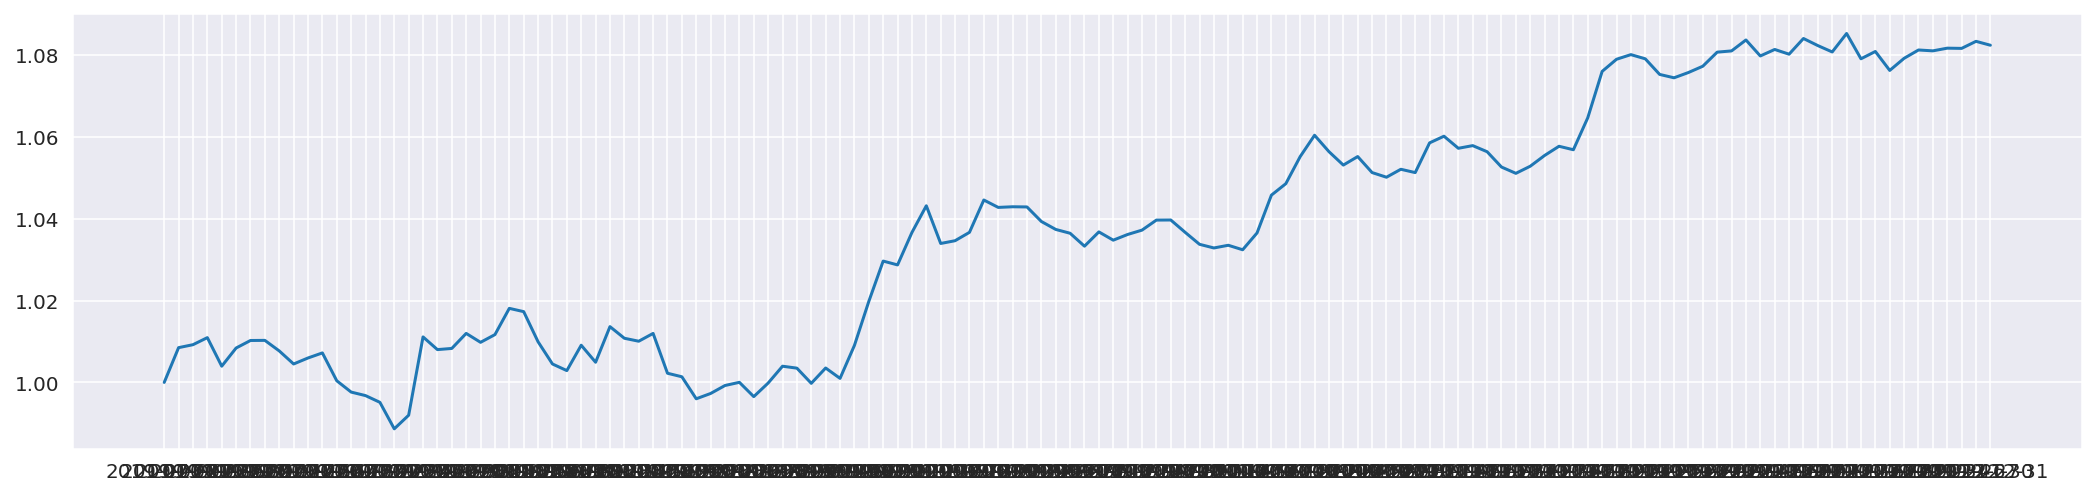

In [30]:
plt.figure(figsize=(18,4))
plt.plot(top_cumret)

In [31]:
results_df.loc['Simple Distance (top10 pairs)'] = calculate_metrics(top_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0


# Distance with Wavelet Transform

In [32]:
import pywt

filtered_train = pd.DataFrame(index=prices_train.index, columns=prices_train.columns)

for stock in tqdm(prices_train.columns):
    ts = prices_train[stock].values
    coeffs = pywt.swt(ts, wavelet='sym12', level=1, trim_approx=True, norm=True)
    filtered_train[stock] = coeffs[0]

100%|██████████| 196/196 [00:00<00:00, 1661.44it/s]


In [33]:
filtered_cumret = (1 + filtered_train.pct_change()).cumprod().dropna()
filtered_cumret = filtered_cumret / filtered_cumret.iloc[0]
filtered_cumret

,AAPL,MSFT,AMZN,TSLA,GOOGL,NVDA,GOOG,...,AZO,ROK,PH,ROST,MPC,DD,PAYX
2017-01-06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-01-09,1.060626,1.085464,1.107274,1.006674,1.023766,1.065872,1.024629,...,1.019207,1.016964,1.013666,1.042396,0.991120,0.972982,1.023557
2017-01-10,1.167832,1.268374,1.315687,1.003547,1.065899,1.153027,1.069247,...,1.069767,1.056036,1.053690,1.125388,1.008066,0.920033,1.080964
2017-01-11,1.157525,1.253394,1.301574,0.999849,1.062673,1.127486,1.064487,...,1.065887,1.063157,1.064884,1.123481,1.011574,0.929294,1.078881
2017-01-12,1.120588,1.190425,1.246335,1.009333,1.050020,1.080973,1.049800,...,1.043797,1.057223,1.061955,1.098197,1.001094,0.948083,1.063911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,1.952916,2.759411,2.978155,0.967413,1.415719,1.614589,1.453910,...,1.477639,1.278141,1.300124,1.752360,1.141531,0.475134,1.622539
2019-06-25,1.919398,2.667218,2.898055,0.963140,1.376018,1.613044,1.413608,...,1.445917,1.263111,1.284581,1.717239,1.135782,0.486820,1.573782
2019-06-26,1.954782,2.683238,2.945836,0.958906,1.365483,1.685638,1.403887,...,1.443142,1.272395,1.293204,1.727047,1.172108,0.472790,1.551975
2019-06-27,1.978190,2.714225,2.985891,0.966303,1.370964,1.749080,1.409234,...,1.450804,1.284005,1.299553,1.721992,1.210847,0.468029,1.547105


In [34]:
pairs_df = pd.DataFrame(columns=['Spread SSD', 'Spread SD'])

for s1 in tqdm(stocks):
    for s2 in stocks:
        if (s1!=s2) and (f'{s2}-{s1}' not in pairs_df.index):
            spread = filtered_cumret[s1] - filtered_cumret[s2]
            ssd = np.sum(spread**2) / len(spread)
            sd = spread.std()
            pairs_df.loc[f'{s1}-{s2}', ['Spread SSD', 'Spread SD']] = ssd, sd

100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


In [35]:
pairs_df.sort_values(by='Spread SSD')

,Spread SSD,Spread SD
GOOGL-GOOG,0.000653,0.011494
JPM-BAC,0.001841,0.041271
SPGI-MCO,0.00224,0.047044
CB-CL,0.002572,0.041014
PEP-KO,0.002659,0.051402
...,...,...
CVS-ALGN,7.552531,1.196035
ALGN-DD,7.624774,1.22749
AIG-ALGN,7.689525,1.197539
ALGN-SLB,8.424977,1.203974


In [36]:
# calculate in-sample Sharpe ratios for top N pairs
N = 200
insample_sharpe = pd.DataFrame(index=pairs_df.sort_values(by='Spread SSD').index[:N], columns=['Sharpe'])

for pair in insample_sharpe.index:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    spread = filtered_cumret[s1] - filtered_cumret[s2]
    sd = pairs_df.loc[pair]['Spread SD'] # historical SD
    
    positions = pd.DataFrame(index=spread.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1)
    insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)

/tmp/ipykernel_565082/2052393310.py:35: RuntimeWarning: invalid value encountered in double_scalars
  insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)


In [37]:
cond1 = insample_sharpe['Sharpe'] > 1
insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False)

,Sharpe
UPS-GILD,2.14836
AON-TT,1.878508
AXP-CCI,1.742133
SO-KMB,1.738971
BMY-GILD,1.733912
...,...
USB-D,1.054474
CMCSA-CB,1.019775
UPS-USB,1.013757
XOM-JCI,1.012136


In [38]:
potential_pairs = insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False).index
len(potential_pairs)

80

In [39]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

for pair in tqdm(potential_pairs):
    s1,s2 = parse_pair(pair)
    
    # construct spread
    spread = cumret_test[s1] - cumret_test[s2]
    sd = pairs_df.loc[pair]['Spread SD'] # historical SD
    
    positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
    
    pair_ret[pair] = ret

100%|██████████| 80/80 [00:00<00:00, 120.26it/s]


In [40]:
pair_cumret = (1 + pair_ret).cumprod()
pair_cumret

,UPS-GILD,AON-TT,AXP-CCI,SO-KMB,BMY-GILD,BRK.B-AMGN,GS-BMY,...,ETN-EMR,ICE-FIS,USB-D,CMCSA-CB,UPS-USB,XOM-JCI,BAC-LMT
2019-07-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
2019-07-02,1.000000,1.000000,1.000000,1.000000,0.995937,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,0.992089,1.000000,0.973947
2019-07-03,1.000000,1.000000,1.000000,1.000000,0.999810,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,0.997763,1.000000,0.963160
2019-07-05,1.000000,1.000000,1.000000,1.000000,0.992233,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,0.982164,1.000000,0.971319
2019-07-08,1.000000,1.000000,1.000000,1.000000,1.004841,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,0.987982,1.000000,0.971270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.957342,1.118148,1.088847,0.978767,1.075108,0.895172,1.170950,...,1.079327,1.066585,1.0,1.027323,1.137172,0.975756,1.125146
2019-12-26,0.946863,1.118148,1.088847,0.978147,1.056173,0.900651,1.162739,...,1.081014,1.068109,1.0,1.022577,1.134847,0.977526,1.125146
2019-12-27,0.941383,1.118148,1.088847,0.979644,1.046200,0.900795,1.156701,...,1.079327,1.061518,1.0,1.026692,1.141818,0.975370,1.125146
2019-12-30,0.946610,1.118148,1.088847,0.973124,1.036707,0.903981,1.159782,...,1.079021,1.063862,1.0,1.021510,1.120494,0.979387,1.125146


In [41]:
# fraction of pairs with positive returns
(pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

0.6125

In [42]:
# fraction of pairs with no positions
(pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

0.1

In [43]:
total_ret = pair_ret.sum(axis=1) / len(pair_ret.columns)

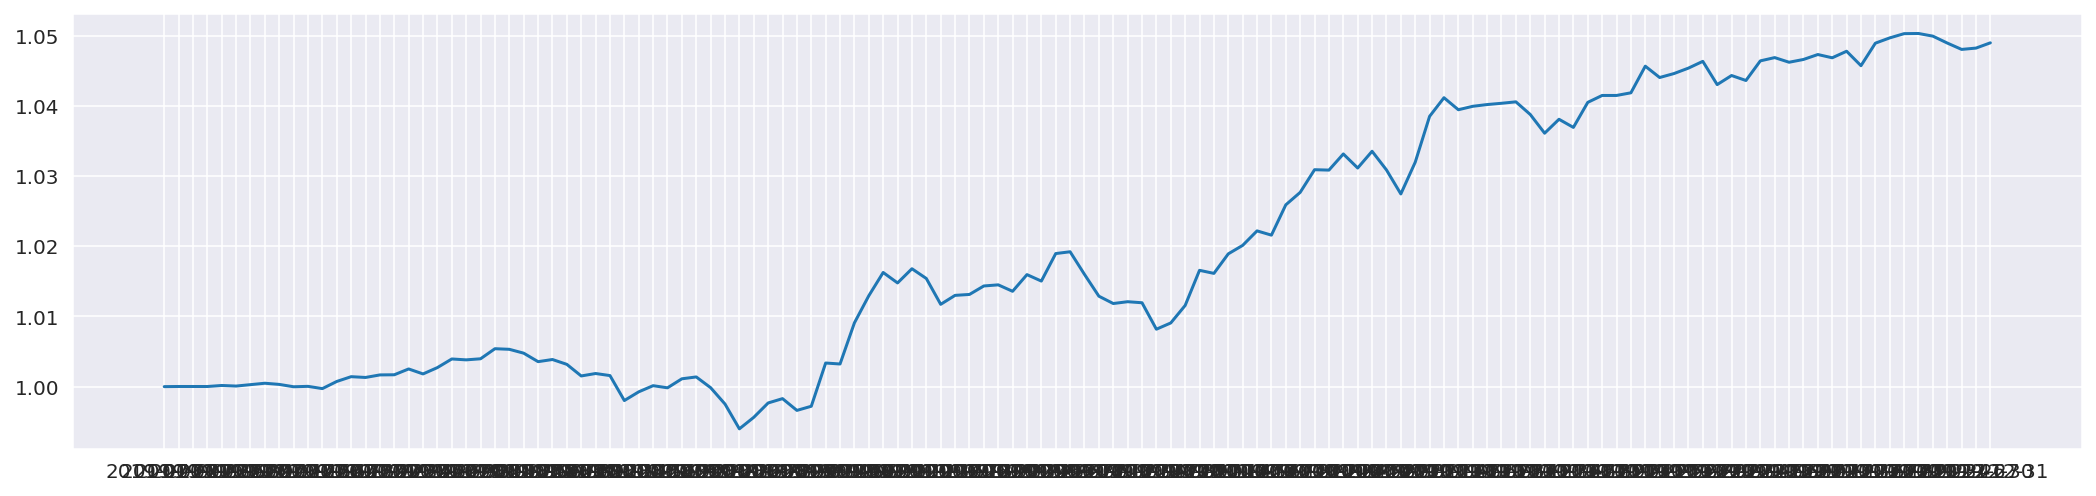

In [44]:
plt.figure(figsize=(18,4))
total_cumret = (1 + total_ret).cumprod()
plt.plot(total_cumret)

In [45]:
results_df.loc['Distance with WT'] = calculate_metrics(total_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0


In [46]:
# save returns and pairs df
pairs_dfs['dist_f'] = pairs_df
pair_rets['dist_f'] = pair_ret
traded_pairs['dist_f'] = pair_ret.columns

### Limit to top 10 pairs consisting of different stocks

In [46]:
selected_pairs = []
selected_stocks = []

# pairs opened on first trading days
for i in range(len(pair_cumret.index)):
    idx = pair_cumret.iloc[i][pair_cumret.iloc[i]!=1].index # pairs opened on day i
    # sort by Sharpe ratio and start selecting
    for pair in insample_sharpe.loc[idx].sort_values(by='Sharpe', ascending=False).index:
        s1,s2 = parse_pair(pair)
        if (s1 not in selected_stocks) and (s2 not in selected_stocks):
            selected_pairs.append(pair)
            selected_stocks.extend([s1,s2])
        if len(selected_pairs)==10:
            break
    if len(selected_pairs)==10:
            break

In [47]:
insample_sharpe.loc[selected_pairs]

,Sharpe
BMY-GILD,1.733912
CCI-AON,1.372068
MS-C,1.0953
T-JCI,1.068527
UPS-USB,1.013757
BAC-LMT,1.005709
BLK-NOC,1.217469
COST-ADP,1.161385
UNP-DG,1.661648
DIS-MDLZ,1.133561


In [48]:
top_ret = pair_ret[selected_pairs].sum(axis=1) / len(selected_pairs)
top_cumret = (1 + top_ret).cumprod()

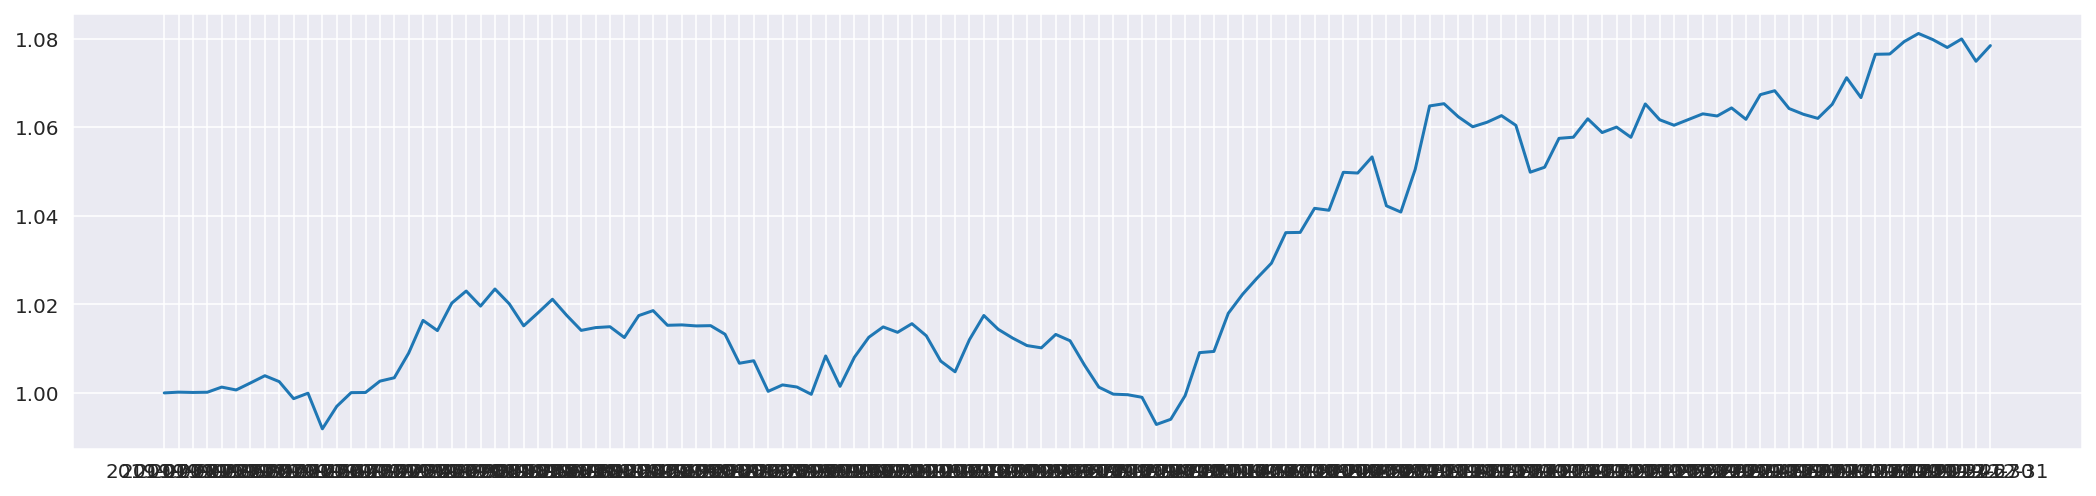

In [49]:
plt.figure(figsize=(18,4))
plt.plot(top_cumret)

In [50]:
results_df.loc['Distance with WT (top10 pairs)'] = calculate_metrics(top_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Distance with WT (top10 pairs),0.078425,0.160259,2.302583,-0.029883,52.0


# Simple Cointegration

In [47]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [48]:
pairs_df = pd.DataFrame(columns=['alpha', 'beta', 'Spread SD', 'ADF', 'Johansen'])

for s1 in tqdm(stocks):
    for s2 in stocks:
        if (s1!=s2) and (f'{s2}-{s1}' not in pairs_df.index):
            adf = 0
            johansen = 0
            
            # construct spread
            res = sm.OLS(prices_train[s1], sm.add_constant(prices_train[s2])).fit()
            alpha,beta = res.params
            spread = res.resid
            sd = spread.std()
            
            adf_pval = adfuller(res.resid)[1]
            if adf_pval < 0.05:
                adf = 1 # null is rejected at 95% level
            
            # Johansen test
            res = coint_johansen(prices_train[[s1,s2]], det_order=0, k_ar_diff=1)
            if (res.lr2 > res.cvm[:,1]).sum() == 2:
                johansen = 1 # null is rejected at 95% level
                
            pairs_df.loc[f'{s1}-{s2}'] = alpha,beta,sd,adf,johansen

100%|██████████| 196/196 [13:20<00:00,  4.09s/it]


In [49]:
pairs_df[(pairs_df['ADF']==1) & (pairs_df['Johansen']==1)]

,alpha,beta,Spread SD,ADF,Johansen
AAPL-XOM,-23.585766,1.005220,5.683504,1.0,1.0
GOOGL-GOOG,48.316999,0.964965,4.943901,1.0,1.0
GOOGL-RTX,-243.508575,23.115928,57.246718,1.0,1.0
NVDA-APTV,-34.532607,1.031142,6.447634,1.0,1.0
GOOG-RTX,-305.697222,24.013561,58.651305,1.0,1.0
...,...,...,...,...,...
MCHP-NEM,8.631788,0.967508,3.836942,1.0,1.0
BK-APTV,26.399745,0.256101,1.880834,1.0,1.0
APTV-CTSH,-9.198060,1.294094,5.398926,1.0,1.0
HPQ-CNC,8.611855,0.192415,1.046483,1.0,1.0


In [50]:
# remove pairs with negative beta
cond1 = (pairs_df['beta'] > 0)
cond2 = (pairs_df['ADF'] == 1)
cond3 = (pairs_df['Johansen'] == 1)
pairs_df.loc[cond1 & cond2 & cond3]

,alpha,beta,Spread SD,ADF,Johansen
AAPL-XOM,-23.585766,1.005220,5.683504,1.0,1.0
GOOGL-GOOG,48.316999,0.964965,4.943901,1.0,1.0
GOOGL-RTX,-243.508575,23.115928,57.246718,1.0,1.0
NVDA-APTV,-34.532607,1.031142,6.447634,1.0,1.0
GOOG-RTX,-305.697222,24.013561,58.651305,1.0,1.0
...,...,...,...,...,...
MCHP-NEM,8.631788,0.967508,3.836942,1.0,1.0
BK-APTV,26.399745,0.256101,1.880834,1.0,1.0
APTV-CTSH,-9.198060,1.294094,5.398926,1.0,1.0
HPQ-CNC,8.611855,0.192415,1.046483,1.0,1.0


In [51]:
potential_pairs = pairs_df.loc[cond1 & cond2 & cond3].index

In [52]:
# calculate in-sample Sharpe ratios for all cointegrated pairs
insample_sharpe = pd.DataFrame(index=potential_pairs, columns=['Sharpe'])

for pair in insample_sharpe.index:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha, beta, sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = prices_train[s1] - alpha - beta * prices_train[s2]
    
    positions = pd.DataFrame(index=spread.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1)
    insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)

In [53]:
insample_sharpe.sort_values(by=['Sharpe'], ascending=False)

,Sharpe
C-GILD,2.187145
BKNG-CTSH,1.959775
BKNG-EOG,1.936013
UPS-ROK,1.896432
HUM-HPQ,1.858207
...,...
RTX-KLAC,0.180952
XOM-APTV,0.074243
USB-MET,-0.007641
XOM-AMAT,-0.018757


In [54]:
potential_pairs = insample_sharpe[insample_sharpe['Sharpe']>1].sort_values(by=['Sharpe'], ascending=False).index
len(potential_pairs)

42

In [55]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

for pair in potential_pairs:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha,beta,sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = prices_test[s1] - alpha - beta * prices_test[s2]
    
    positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
    
    pair_ret[pair] = ret

In [56]:
pair_cumret = (1 + pair_ret).cumprod()
pair_cumret

,C-GILD,BKNG-CTSH,BKNG-EOG,UPS-ROK,HUM-HPQ,APTV-CTSH,AAPL-XOM,...,USB-ROK,BKNG-USB,GILD-USB,XOM-RTX,MCHP-ALGN,XOM-ROK,LRCX-MAR
2019-07-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.963460,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.962083,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.907225,0.955447,1.078899,1.196809,0.831028,0.864942,0.709210,...,1.104312,1.0,0.949207,0.858971,0.929914,0.738727,0.810358
2019-12-26,0.888424,0.941661,1.066113,1.196809,0.832199,0.853495,0.696254,...,1.102942,1.0,0.936877,0.853773,0.923363,0.734862,0.817866
2019-12-27,0.884316,0.938518,1.055368,1.196809,0.822634,0.848784,0.694135,...,1.103892,1.0,0.937209,0.853287,0.925228,0.736845,0.819113
2019-12-30,0.872415,0.939272,1.055355,1.196809,0.826973,0.851162,0.685943,...,1.106262,1.0,0.924911,0.850553,0.922828,0.732668,0.817736


In [61]:
# fraction of pairs with positive returns
(pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

0.30952380952380953

In [62]:
# fraction of pairs with no positions
(pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

0.19047619047619047

In [57]:
total_ret = pair_ret.sum(axis=1) / len(pair_ret.columns)

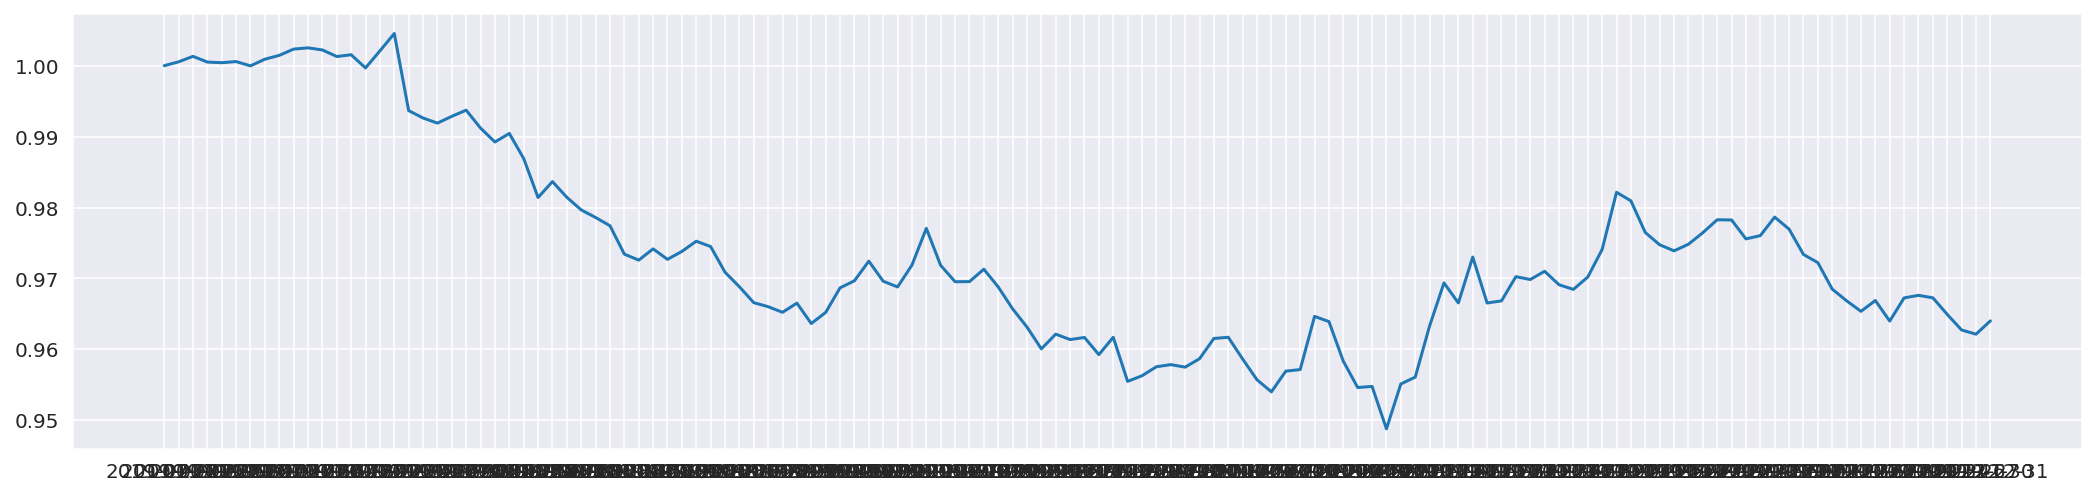

In [58]:
plt.figure(figsize=(18,4))
total_cumret = (1 + total_ret).cumprod()
plt.plot(total_cumret)

In [59]:
results_df.loc['Simple Cointegration'] = calculate_metrics(total_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Simple Cointegration,-0.035992,-0.069623,-1.503482,-0.055507,111.0


In [60]:
# save returns and pairs df
pairs_dfs['coint_nf'] = pairs_df
pair_rets['coint_nf'] = pair_ret
traded_pairs['coint_nf'] = pair_ret.columns

### Limit to top 10 pairs consisting of different stocks

In [65]:
selected_pairs = []
selected_stocks = []

# pairs opened on first trading days
for i in range(len(pair_cumret.index)):
    idx = pair_cumret.iloc[i][pair_cumret.iloc[i]!=1].index # pairs opened on day i
    # sort by Sharpe ratio and start selecting
    for pair in insample_sharpe.loc[idx].sort_values(by='Sharpe', ascending=False).index:
        s1,s2 = parse_pair(pair)
        if (s1 not in selected_stocks) and (s2 not in selected_stocks):
            selected_pairs.append(pair)
            selected_stocks.extend([s1,s2])
        if len(selected_pairs)==10:
            break
    if len(selected_pairs)==10:
            break

In [66]:
insample_sharpe.loc[selected_pairs]

,Sharpe
KLAC-ALGN,1.574646
BK-APTV,1.242081
USB-ROK,1.12782
FB-MCHP,1.364982
AVGO-ORCL,1.49446
MS-NEM,1.155944
C-GILD,2.187145
CL-PRU,1.627864
BRK.B-SHW,1.256964
AAPL-XOM,1.834817


In [67]:
top_ret = pair_ret[selected_pairs].sum(axis=1) / len(selected_pairs)
top_cumret = (1 + top_ret).cumprod()

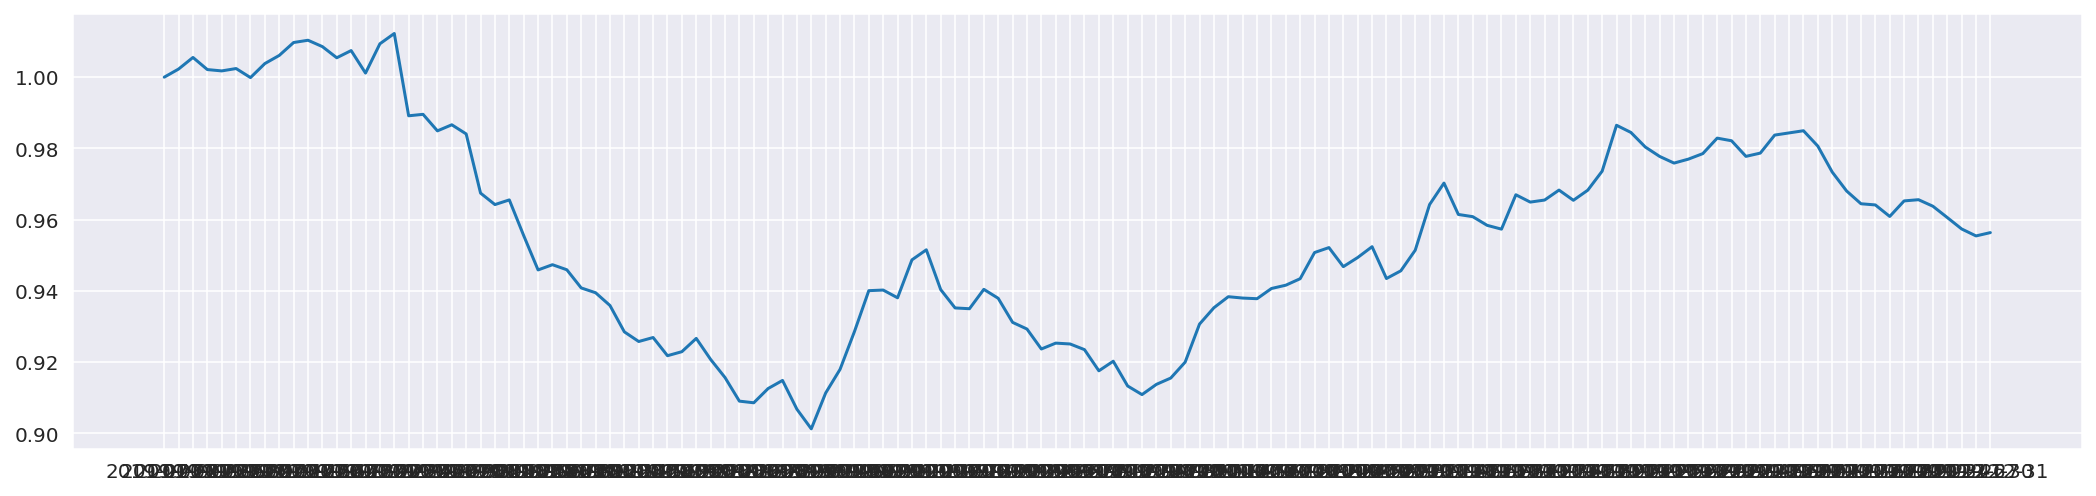

In [68]:
plt.figure(figsize=(18,4))
plt.plot(top_cumret)

In [69]:
results_df.loc['Simple Cointegration (top10 pairs)'] = calculate_metrics(top_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Distance with WT (top10 pairs),0.078425,0.160259,2.302583,-0.029883,52.0
Simple Cointegration,-0.035992,-0.069623,-1.503482,-0.055507,111.0
Simple Cointegration (top10 pairs),-0.043637,-0.084093,-0.931237,-0.109663,111.0


# Cointegration with Wavelet Transform

In [63]:
pairs_df = pd.DataFrame(columns=['alpha', 'beta', 'Spread SD', 'ADF', 'Johansen'])

for s1 in tqdm(stocks):
    for s2 in stocks:
        if (s1!=s2) and (f'{s2}-{s1}' not in pairs_df.index):
            adf = 0
            johansen = 0
            
            # construct spread
            res = sm.OLS(filtered_train[s1], sm.add_constant(filtered_train[s2])).fit()
            alpha,beta = res.params
            spread = res.resid
            sd = spread.std()
            
            adf_pval = adfuller(res.resid)[1]
            if adf_pval < 0.05:
                adf = 1 # null is rejected at 95% level
            
            # Johansen test
            res = coint_johansen(filtered_train[[s1,s2]], det_order=0, k_ar_diff=1)
            if (res.lr2 > res.cvm[:,1]).sum() == 2:
                johansen = 1 # null is rejected at 95% level
                
            pairs_df.loc[f'{s1}-{s2}'] = alpha,beta,sd,adf,johansen

100%|██████████| 196/196 [13:47<00:00,  4.22s/it]


In [64]:
pairs_df[(pairs_df['ADF']==1) & (pairs_df['Johansen']==1)]

,alpha,beta,Spread SD,ADF,Johansen
AAPL-AMZN,20.988251,0.014644,2.955899,1.0,1.0
AAPL-GOOGL,-8.111440,0.047032,3.241914,1.0,1.0
AAPL-GOOG,-5.932989,0.045475,3.231263,1.0,1.0
AAPL-BRK.B,-18.787901,0.313161,3.573869,1.0,1.0
AAPL-JPM,-6.334235,0.517414,3.488712,1.0,1.0
...,...,...,...,...,...
CTSH-MPC,35.700180,0.589089,4.466187,1.0,1.0
SIVB-MPC,-22.588886,4.733004,19.121945,1.0,1.0
AEP-SLB,97.487062,-0.613823,2.900027,1.0,1.0
ROK-PH,2.203453,0.988882,4.643548,1.0,1.0


In [66]:
# remove pairs with negative beta
cond1 = (pairs_df['beta'] > 0)
cond2 = (pairs_df['ADF'] == 1)
cond3 = (pairs_df['Johansen'] == 1)
pairs_df.loc[cond1 & cond2 & cond3]

,alpha,beta,Spread SD,ADF,Johansen
AAPL-AMZN,20.988251,0.014644,2.955899,1.0,1.0
AAPL-GOOGL,-8.111440,0.047032,3.241914,1.0,1.0
AAPL-GOOG,-5.932989,0.045475,3.231263,1.0,1.0
AAPL-BRK.B,-18.787901,0.313161,3.573869,1.0,1.0
AAPL-JPM,-6.334235,0.517414,3.488712,1.0,1.0
...,...,...,...,...,...
CTSH-ROK,8.351969,0.370317,4.934032,1.0,1.0
CTSH-PH,17.942955,0.311026,5.838282,1.0,1.0
CTSH-MPC,35.700180,0.589089,4.466187,1.0,1.0
SIVB-MPC,-22.588886,4.733004,19.121945,1.0,1.0


In [67]:
potential_pairs = pairs_df.loc[cond1 & cond2 & cond3].index

In [68]:
# calculate in-sample Sharpe ratios for all cointegrated pairs
insample_sharpe = pd.DataFrame(index=potential_pairs, columns=['Sharpe'])

for pair in tqdm(insample_sharpe.index):
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha, beta, sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = filtered_train[s1] - alpha - beta * filtered_train[s2]
    
    positions = pd.DataFrame(index=spread.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1) 
    insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)

 32%|███▏      | 987/3055 [00:18<00:38, 53.95it/s]/tmp/ipykernel_565082/4269585369.py:34: RuntimeWarning: invalid value encountered in double_scalars
  insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)
100%|██████████| 3055/3055 [00:55<00:00, 55.51it/s]


In [69]:
insample_sharpe.sort_values(by=['Sharpe'], ascending=False)

,Sharpe
AMAT-GS,2.522606
ADBE-CVX,2.42227
CVX-MCO,2.394544
AMGN-BDX,2.343173
AMGN-FTNT,2.329574
...,...
XOM-SLB,-0.836267
XOM-NXPI,-0.921824
BK-MAR,-0.926298
WFC-GE,-0.954221


In [70]:
potential_pairs = insample_sharpe[insample_sharpe['Sharpe']>1].sort_values(by=['Sharpe'], ascending=False).index
len(potential_pairs)

1569

In [71]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

for pair in tqdm(potential_pairs):
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha,beta,sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = prices_test[s1] - alpha - beta * prices_test[s2]
    
    positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
    
    pair_ret[pair] = ret

100%|██████████| 1569/1569 [00:15<00:00, 103.33it/s]


In [72]:
pair_cumret = (1 + pair_ret).cumprod()
pair_cumret

,AMAT-GS,ADBE-CVX,CVX-MCO,AMGN-BDX,AMGN-FTNT,PLD-MMC,ANTM-ROST,...,TMO-PLD,GOOGL-GOOG,CB-MCHP,JPM-ALGN,CRM-ISRG,CHTR-CL,PNC-LMT
2019-07-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,0.998178,1.000000,1.000000,1.000000,1.000000
2019-07-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,0.984903,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.908640,0.983701,0.905944,1.129428,1.117971,1.062822,1.076857,...,1.094881,1.0,1.133727,0.810005,1.124141,0.813881,1.106726
2019-12-26,0.916585,0.981172,0.904554,1.123365,1.124726,1.066903,1.075999,...,1.085344,1.0,1.137259,0.802487,1.124141,0.805994,1.106726
2019-12-27,0.916498,0.979945,0.901396,1.132502,1.118237,1.068228,1.085126,...,1.084951,1.0,1.124564,0.800122,1.124141,0.816431,1.106726
2019-12-30,0.916677,0.983538,0.904201,1.128739,1.118867,1.072424,1.066659,...,1.077610,1.0,1.123021,0.797262,1.124141,0.812858,1.106726


In [73]:
# fraction of pairs with positive returns
(pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

0.5149776927979605

In [74]:
# fraction of pairs with no positions
(pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

0.13575525812619502

In [75]:
total_ret = pair_ret.sum(axis=1) / pair_ret.shape[1]

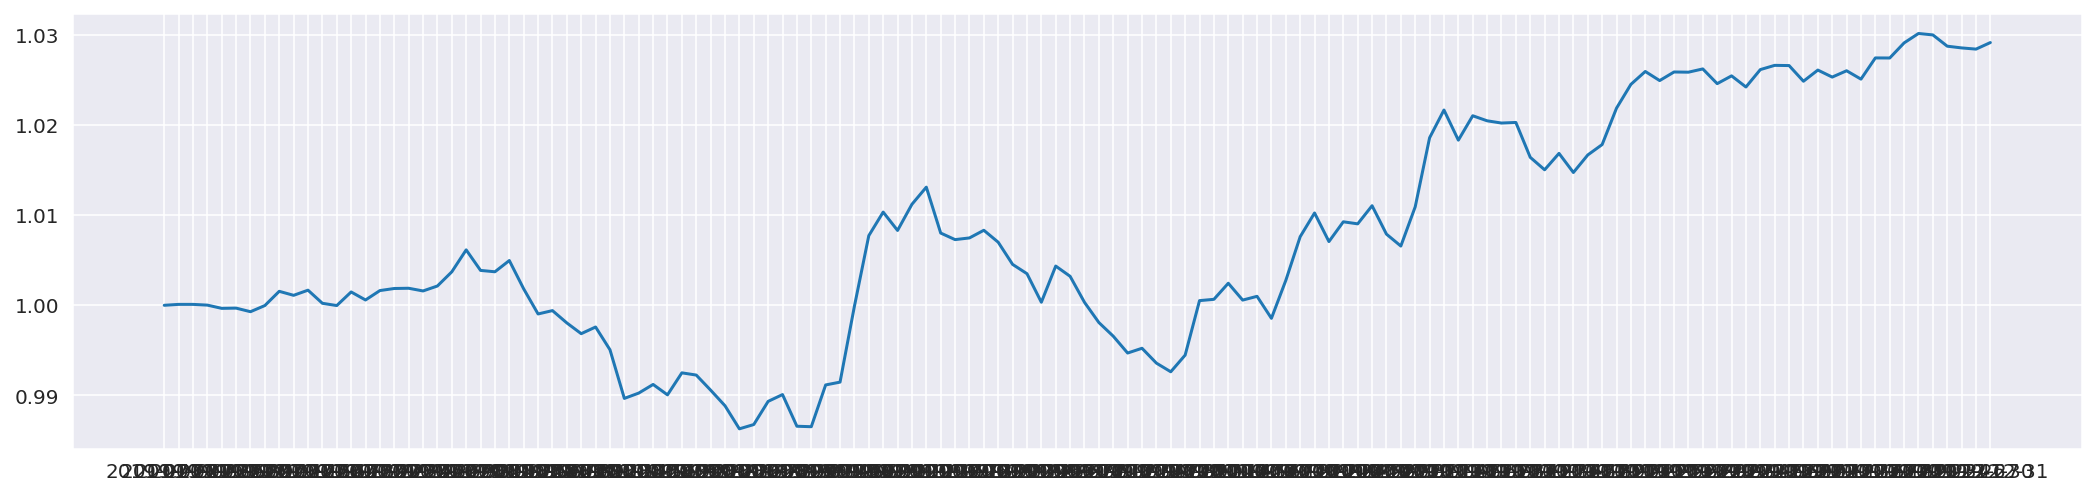

In [76]:
plt.figure(figsize=(18,4))
total_cumret = (1 + total_ret).cumprod()
plt.plot(total_cumret)

In [77]:
results_df.loc['Cointegration with WT'] = calculate_metrics(total_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Simple Cointegration,-0.035992,-0.069623,-1.503482,-0.055507,111.0
Cointegration with WT,0.029183,0.058267,1.545514,-0.020241,34.0


In [78]:
# save returns and pairs df
pairs_dfs['coint_f'] = pairs_df
pair_rets['coint_f'] = pair_ret
traded_pairs['coint_f'] = pair_ret.columns

### Limit to top 10 pairs consisting of different stocks

In [79]:
selected_pairs = []
selected_stocks = []

# pairs opened on first trading days
for i in range(len(pair_cumret.index)):
    idx = pair_cumret.iloc[i][pair_cumret.iloc[i]!=1].index # pairs opened on day i
    # sort by Sharpe ratio and start selecting
    for pair in insample_sharpe.loc[idx].sort_values(by='Sharpe', ascending=False).index:
        s1,s2 = parse_pair(pair)
        if (s1 not in selected_stocks) and (s2 not in selected_stocks):
            selected_pairs.append(pair)
            selected_stocks.extend([s1,s2])
        if len(selected_pairs)==10:
            break
    if len(selected_pairs)==10:
            break

In [80]:
insample_sharpe.loc[selected_pairs]

,Sharpe
SYK-ROST,2.148488
CHTR-AIG,2.094796
ORCL-CME,2.078306
PEP-CB,2.034565
LOW-INFO,1.976852
BMY-GILD,1.936287
TMO-EW,1.853482
ABBV-PNC,1.814657
MDT-AMGN,1.787613
BLK-TEL,1.761865


In [81]:
top_ret = pair_ret[selected_pairs].sum(axis=1) / len(selected_pairs)
top_cumret = (1 + top_ret).cumprod()

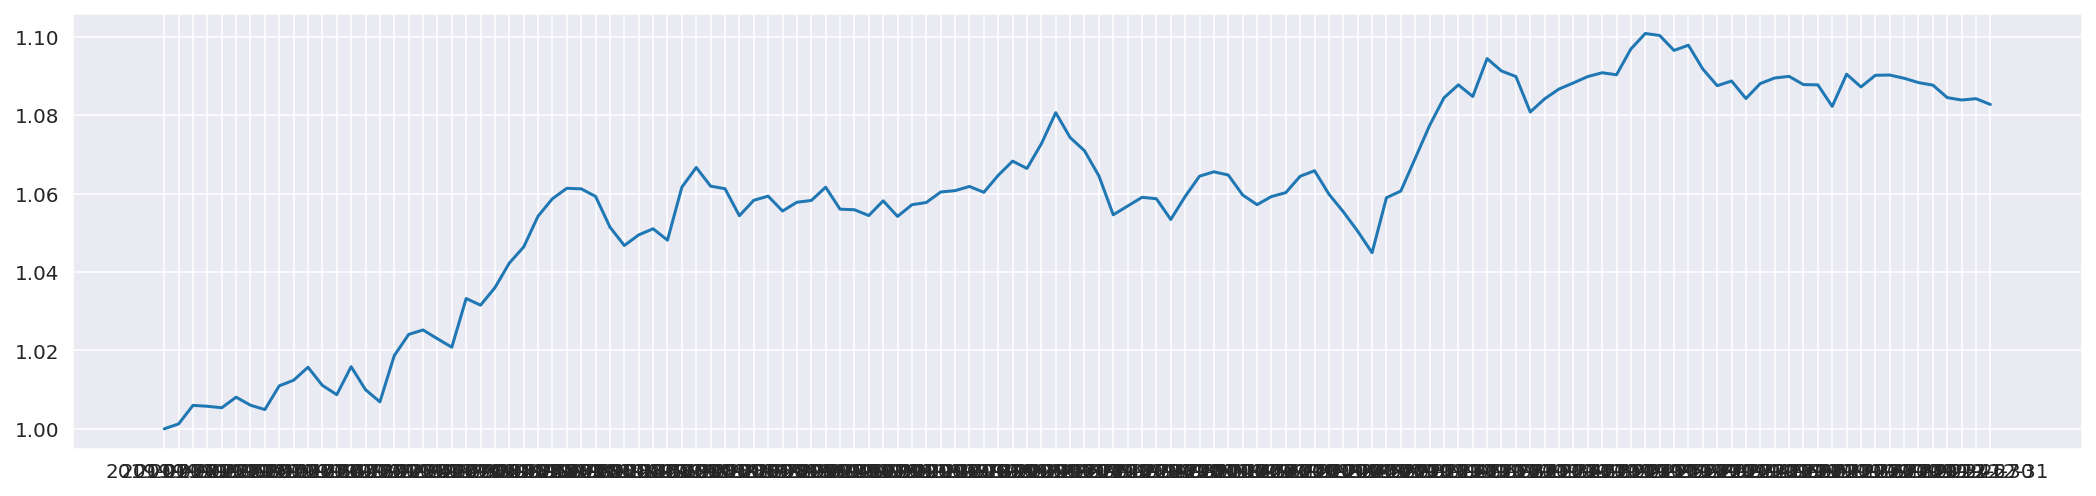

In [82]:
plt.figure(figsize=(18,4))
plt.plot(top_cumret)

In [83]:
results_df.loc['Cointegration with WT (top10 pairs)'] = calculate_metrics(top_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Simple Cointegration,-0.035992,-0.069623,-1.503482,-0.055507,111.0
Cointegration with WT,0.029183,0.058267,1.545514,-0.020241,34.0
Cointegration with WT (top10 pairs),0.082723,0.169381,2.300404,-0.033048,26.0


# Simple Granger Causality

In [84]:
pairs_df = pairs_dfs['coint_nf']

In [85]:
cond1 = (pairs_df['beta'] > 0)
cond2 = (pairs_df['ADF'] == 1)
cond3 = (pairs_df['Johansen'] == 1)
pairs_df[cond1 & cond2 & cond3]

,alpha,beta,Spread SD,ADF,Johansen
AAPL-XOM,-23.585766,1.005220,5.683504,1.0,1.0
GOOGL-GOOG,48.316999,0.964965,4.943901,1.0,1.0
GOOGL-RTX,-243.508575,23.115928,57.246718,1.0,1.0
NVDA-APTV,-34.532607,1.031142,6.447634,1.0,1.0
GOOG-RTX,-305.697222,24.013561,58.651305,1.0,1.0
...,...,...,...,...,...
MCHP-NEM,8.631788,0.967508,3.836942,1.0,1.0
BK-APTV,26.399745,0.256101,1.880834,1.0,1.0
APTV-CTSH,-9.198060,1.294094,5.398926,1.0,1.0
HPQ-CNC,8.611855,0.192415,1.046483,1.0,1.0


In [86]:
granger_df = pairs_df[cond1 & cond2 & cond3].copy()
granger_df['gc12'] = np.zeros(len(granger_df))
granger_df['gc21'] = np.zeros(len(granger_df))
granger_df

,alpha,beta,Spread SD,ADF,Johansen,gc12,gc21
AAPL-XOM,-23.585766,1.005220,5.683504,1.0,1.0,0.0,0.0
GOOGL-GOOG,48.316999,0.964965,4.943901,1.0,1.0,0.0,0.0
GOOGL-RTX,-243.508575,23.115928,57.246718,1.0,1.0,0.0,0.0
NVDA-APTV,-34.532607,1.031142,6.447634,1.0,1.0,0.0,0.0
GOOG-RTX,-305.697222,24.013561,58.651305,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
MCHP-NEM,8.631788,0.967508,3.836942,1.0,1.0,0.0,0.0
BK-APTV,26.399745,0.256101,1.880834,1.0,1.0,0.0,0.0
APTV-CTSH,-9.198060,1.294094,5.398926,1.0,1.0,0.0,0.0
HPQ-CNC,8.611855,0.192415,1.046483,1.0,1.0,0.0,0.0


In [87]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15

for pair in granger_df.index:
    s1,s2 = parse_pair(pair)
    
    gct12 = grangercausalitytests(prices_train[[s1,s2]], maxlag=maxlag, verbose=False)
    pvals12 = [gct12[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
    pvals12 = np.array(pvals12)
    if len(pvals12[pvals12<0.05])>0:
        granger_df.loc[pair, ['gc12']] = 1
    
    gct21 = grangercausalitytests(prices_train[[s2,s1]], maxlag=maxlag, verbose=False)
    pvals21 = [gct21[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
    pvals21 = np.array(pvals21)
    if len(pvals21[pvals21<0.05])>0:
        granger_df.loc[pair, ['gc21']] = 1

In [88]:
cond = ((granger_df['gc12'] == 1) & (granger_df['gc21'] == 1))
granger_df[cond]

,alpha,beta,Spread SD,ADF,Johansen,gc12,gc21
AAPL-XOM,-23.585766,1.005220,5.683504,1.0,1.0,1.0,1.0
GOOGL-RTX,-243.508575,23.115928,57.246718,1.0,1.0,1.0,1.0
GOOG-RTX,-305.697222,24.013561,58.651305,1.0,1.0,1.0,1.0
FB-C,3.490749,2.710081,12.848035,1.0,1.0,1.0,1.0
FB-MCHP,19.986147,3.661837,9.999151,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
ETN-KLAC,32.630450,0.387500,2.745536,1.0,1.0,1.0,1.0
COF-TEL,36.499802,0.592758,4.258121,1.0,1.0,1.0,1.0
KLAC-ALGN,75.182179,0.089524,7.609116,1.0,1.0,1.0,1.0
HUM-HPQ,0.239252,13.939809,15.549478,1.0,1.0,1.0,1.0


In [89]:
potential_pairs = granger_df[cond].index

In [90]:
# calculate in-sample Sharpe ratios for all cointegrated pairs
insample_sharpe = pd.DataFrame(index=potential_pairs, columns=['Sharpe'])

for pair in insample_sharpe.index:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha, beta, sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = prices_train[s1] - alpha - beta * prices_train[s2]
    
    positions = pd.DataFrame(index=spread.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1) 
    insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)

In [91]:
insample_sharpe.sort_values(by=['Sharpe'], ascending=False)

,Sharpe
HUM-HPQ,1.858207
APTV-CTSH,1.854987
AAPL-XOM,1.834817
LRCX-NOC,1.621341
KLAC-ALGN,1.574646
...,...
COF-TEL,0.699564
QCOM-KLAC,0.694544
RTX-APH,0.599182
RTX-KLAC,0.180952


In [92]:
potential_pairs = insample_sharpe[insample_sharpe['Sharpe']>1].sort_values(by=['Sharpe'], ascending=False).index
len(potential_pairs)

14

In [93]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

for pair in potential_pairs:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha,beta,sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = prices_test[s1] - alpha - beta * prices_test[s2]
    
    positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
    
    pair_ret[pair] = ret

In [94]:
pair_cumret = (1 + pair_ret).cumprod()
pair_cumret

,HUM-HPQ,APTV-CTSH,AAPL-XOM,LRCX-NOC,KLAC-ALGN,XOM-SHW,CMCSA-CHTR,AVGO-ORCL,MU-APTV,GOOG-RTX,FB-MCHP,UPS-APTV,XOM-PH,GOOGL-RTX
2019-07-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0
2019-07-02,1.000000,1.000000,1.000000,1.000000,1.014300,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0
2019-07-03,1.000000,1.000000,1.000000,1.000000,1.034484,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0
2019-07-05,1.000000,1.000000,1.000000,1.000000,1.038130,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0
2019-07-08,1.000000,1.000000,1.000000,1.000000,1.038984,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.831028,0.864942,0.709210,0.867048,0.671350,0.858939,0.999168,1.084546,1.0,1.0,1.134928,1.157185,0.784193,1.0
2019-12-26,0.832199,0.853495,0.696254,0.867951,0.669832,0.859608,0.998921,1.095712,1.0,1.0,1.134928,1.160364,0.780904,1.0
2019-12-27,0.822634,0.848784,0.694135,0.867750,0.669201,0.856533,1.006004,1.098458,1.0,1.0,1.134928,1.168491,0.780601,1.0
2019-12-30,0.826973,0.851162,0.685943,0.877765,0.664919,0.855853,1.009057,1.093496,1.0,1.0,1.134928,1.180191,0.780698,1.0


In [95]:
# fraction of pairs with positive returns
(pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

0.2857142857142857

In [96]:
# fraction of pairs with no positions
(pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

0.21428571428571427

In [97]:
total_ret = pair_ret.sum(axis=1) / len(pair_ret.columns)

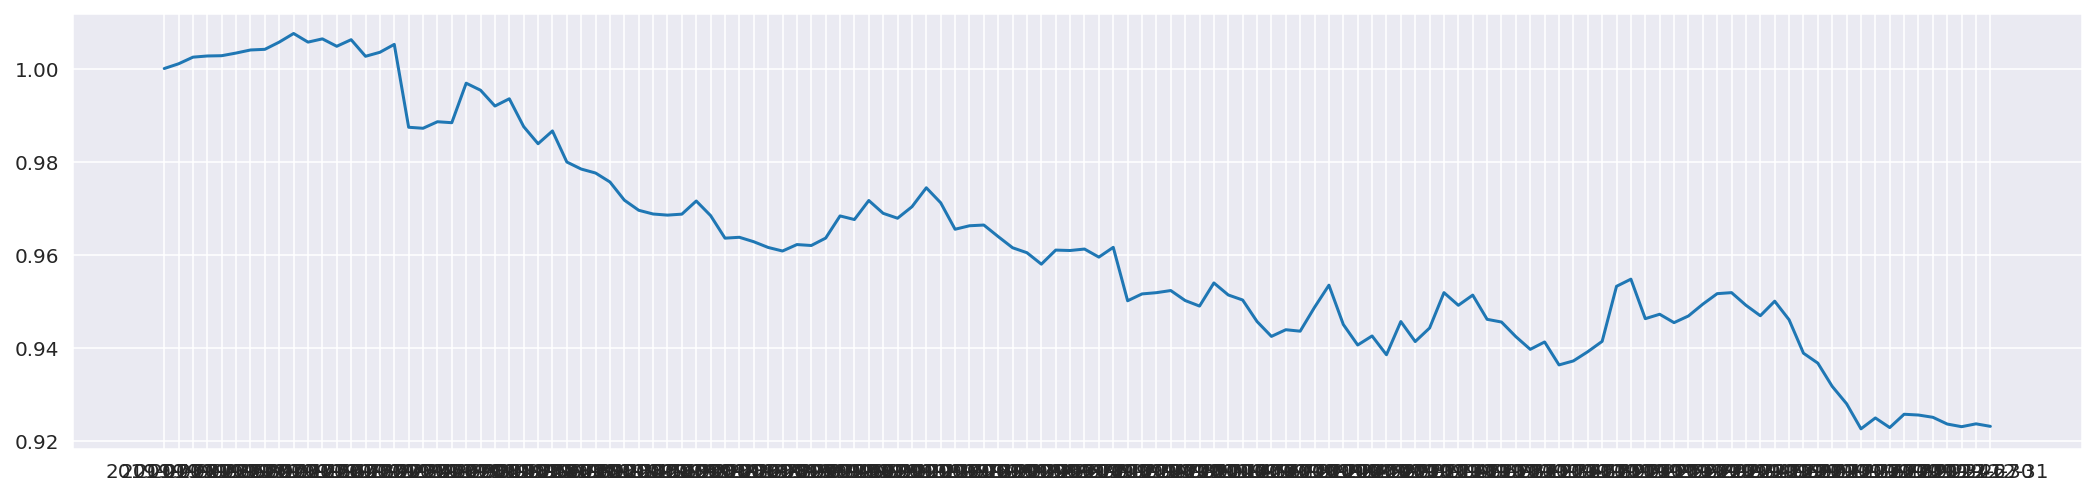

In [98]:
plt.figure(figsize=(18,4))
total_cumret = (1 + total_ret).cumprod()
plt.plot(total_cumret)

In [99]:
results_df.loc['Simple G-c'] = calculate_metrics(total_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Simple Cointegration,-0.035992,-0.069623,-1.503482,-0.055507,111.0
Cointegration with WT,0.029183,0.058267,1.545514,-0.020241,34.0
Cointegration with WT (top10 pairs),0.082723,0.169381,2.300404,-0.033048,26.0
Simple G-c,-0.076815,-0.145598,-2.568052,-0.084236,118.0


In [100]:
# save returns and pairs df
pairs_dfs['granger_nf'] = pairs_df
pair_rets['granger_nf'] = pair_ret
traded_pairs['granger_nf'] = pair_ret.columns

# Granger Causality with Wavelet Transform

In [101]:
pairs_df = pairs_dfs['coint_f']

In [102]:
cond1 = (pairs_df['beta'] > 0)
cond2 = (pairs_df['ADF'] == 1)
cond3 = (pairs_df['Johansen'] == 1)
pairs_df[cond1 & cond2 & cond3]

,alpha,beta,Spread SD,ADF,Johansen
AAPL-AMZN,20.988251,0.014644,2.955899,1.0,1.0
AAPL-GOOGL,-8.111440,0.047032,3.241914,1.0,1.0
AAPL-GOOG,-5.932989,0.045475,3.231263,1.0,1.0
AAPL-BRK.B,-18.787901,0.313161,3.573869,1.0,1.0
AAPL-JPM,-6.334235,0.517414,3.488712,1.0,1.0
...,...,...,...,...,...
CTSH-ROK,8.351969,0.370317,4.934032,1.0,1.0
CTSH-PH,17.942955,0.311026,5.838282,1.0,1.0
CTSH-MPC,35.700180,0.589089,4.466187,1.0,1.0
SIVB-MPC,-22.588886,4.733004,19.121945,1.0,1.0


In [103]:
granger_df = pairs_df[cond1 & cond2 & cond3].copy()
granger_df['gc12'] = np.zeros(len(granger_df))
granger_df['gc21'] = np.zeros(len(granger_df))
granger_df

,alpha,beta,Spread SD,ADF,Johansen,gc12,gc21
AAPL-AMZN,20.988251,0.014644,2.955899,1.0,1.0,0.0,0.0
AAPL-GOOGL,-8.111440,0.047032,3.241914,1.0,1.0,0.0,0.0
AAPL-GOOG,-5.932989,0.045475,3.231263,1.0,1.0,0.0,0.0
AAPL-BRK.B,-18.787901,0.313161,3.573869,1.0,1.0,0.0,0.0
AAPL-JPM,-6.334235,0.517414,3.488712,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
CTSH-ROK,8.351969,0.370317,4.934032,1.0,1.0,0.0,0.0
CTSH-PH,17.942955,0.311026,5.838282,1.0,1.0,0.0,0.0
CTSH-MPC,35.700180,0.589089,4.466187,1.0,1.0,0.0,0.0
SIVB-MPC,-22.588886,4.733004,19.121945,1.0,1.0,0.0,0.0


In [104]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15

for pair in tqdm(granger_df.index):
    s1,s2 = parse_pair(pair)
    
    gct12 = grangercausalitytests(filtered_train[[s1,s2]], maxlag=maxlag, verbose=False)
    pvals12 = [gct12[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
    pvals12 = np.array(pvals12)
    if len(pvals12[pvals12<0.05])>0:
        granger_df.loc[pair, ['gc12']] = 1
    
    gct21 = grangercausalitytests(filtered_train[[s2,s1]], maxlag=maxlag, verbose=False)
    pvals21 = [gct21[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
    pvals21 = np.array(pvals21)
    if len(pvals21[pvals21<0.05])>0:
        granger_df.loc[pair, ['gc21']] = 1

100%|██████████| 3055/3055 [10:28<00:00,  4.86it/s]


In [106]:
cond = ((granger_df['gc12'] == 1) & (granger_df['gc21'] == 1))
granger_df[cond]

,alpha,beta,Spread SD,ADF,Johansen,gc12,gc21
AAPL-GOOGL,-8.111440,0.047032,3.241914,1.0,1.0,1.0,1.0
AAPL-GOOG,-5.932989,0.045475,3.231263,1.0,1.0,1.0,1.0
AAPL-BRK.B,-18.787901,0.313161,3.573869,1.0,1.0,1.0,1.0
AAPL-JPM,-6.334235,0.517414,3.488712,1.0,1.0,1.0,1.0
AAPL-HD,-1.390730,0.265432,3.101237,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
HPQ-CNC,8.610354,0.192443,1.037843,1.0,1.0,1.0,1.0
LHX-ROST,24.427758,1.432555,12.066099,1.0,1.0,1.0,1.0
CTSH-PH,17.942955,0.311026,5.838282,1.0,1.0,1.0,1.0
SIVB-MPC,-22.588886,4.733004,19.121945,1.0,1.0,1.0,1.0


In [107]:
potential_pairs = granger_df[cond].index

In [108]:
# calculate in-sample Sharpe ratios for all cointegrated pairs
insample_sharpe = pd.DataFrame(index=potential_pairs, columns=['Sharpe'])

for pair in tqdm(insample_sharpe.index):
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha, beta, sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = filtered_train[s1] - alpha - beta * filtered_train[s2]
    
    positions = pd.DataFrame(index=spread.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1) 
    insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)

 33%|███▎      | 791/2370 [00:14<00:29, 54.22it/s]/tmp/ipykernel_565082/4269585369.py:34: RuntimeWarning: invalid value encountered in double_scalars
  insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)
100%|██████████| 2370/2370 [00:42<00:00, 55.88it/s]


In [109]:
insample_sharpe.sort_values(by=['Sharpe'], ascending=False)

,Sharpe
AMAT-GS,2.522606
PLD-MMC,2.285362
ANTM-ROST,2.281866
TMO-PGR,2.254381
UNP-EW,2.19732
...,...
XOM-SLB,-0.836267
XOM-NXPI,-0.921824
BK-MAR,-0.926298
WFC-GE,-0.954221


In [110]:
potential_pairs = insample_sharpe[insample_sharpe['Sharpe']>1].sort_values(by=['Sharpe'], ascending=False).index
len(potential_pairs)

1232

In [111]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

for pair in potential_pairs:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    alpha,beta,sd = pairs_df.loc[pair, ['alpha', 'beta', 'Spread SD']]
    spread = prices_test[s1] - alpha - beta * prices_test[s2]
    
    positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
    
    pair_ret[pair] = ret

In [112]:
pair_cumret = (1 + pair_ret).cumprod()
pair_cumret

,AMAT-GS,PLD-MMC,ANTM-ROST,TMO-PGR,UNP-EW,LOW-CME,ABBV-CTSH,...,TMO-PLD,GOOGL-GOOG,CB-MCHP,JPM-ALGN,CRM-ISRG,CHTR-CL,PNC-LMT
2019-07-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2019-07-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,0.998178,1.000000,1.000000,1.000000,1.000000
2019-07-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,0.984903,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.908640,1.062822,1.076857,0.818265,0.937734,1.151561,0.942280,...,1.094881,1.0,1.133727,0.810005,1.124141,0.813881,1.106726
2019-12-26,0.916585,1.066903,1.075999,0.818675,0.942570,1.151561,0.938262,...,1.085344,1.0,1.137259,0.802487,1.124141,0.805994,1.106726
2019-12-27,0.916498,1.068228,1.085126,0.821358,0.950375,1.151561,0.945446,...,1.084951,1.0,1.124564,0.800122,1.124141,0.816431,1.106726
2019-12-30,0.916677,1.072424,1.066659,0.827091,0.952645,1.151561,0.944897,...,1.077610,1.0,1.123021,0.797262,1.124141,0.812858,1.106726


In [113]:
# fraction of pairs with positive returns
(pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

0.5292207792207793

In [114]:
# fraction of pairs with no positions
(pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

0.13068181818181818

In [117]:
total_ret = pair_ret.sum(axis=1) / len(pair_ret.columns)

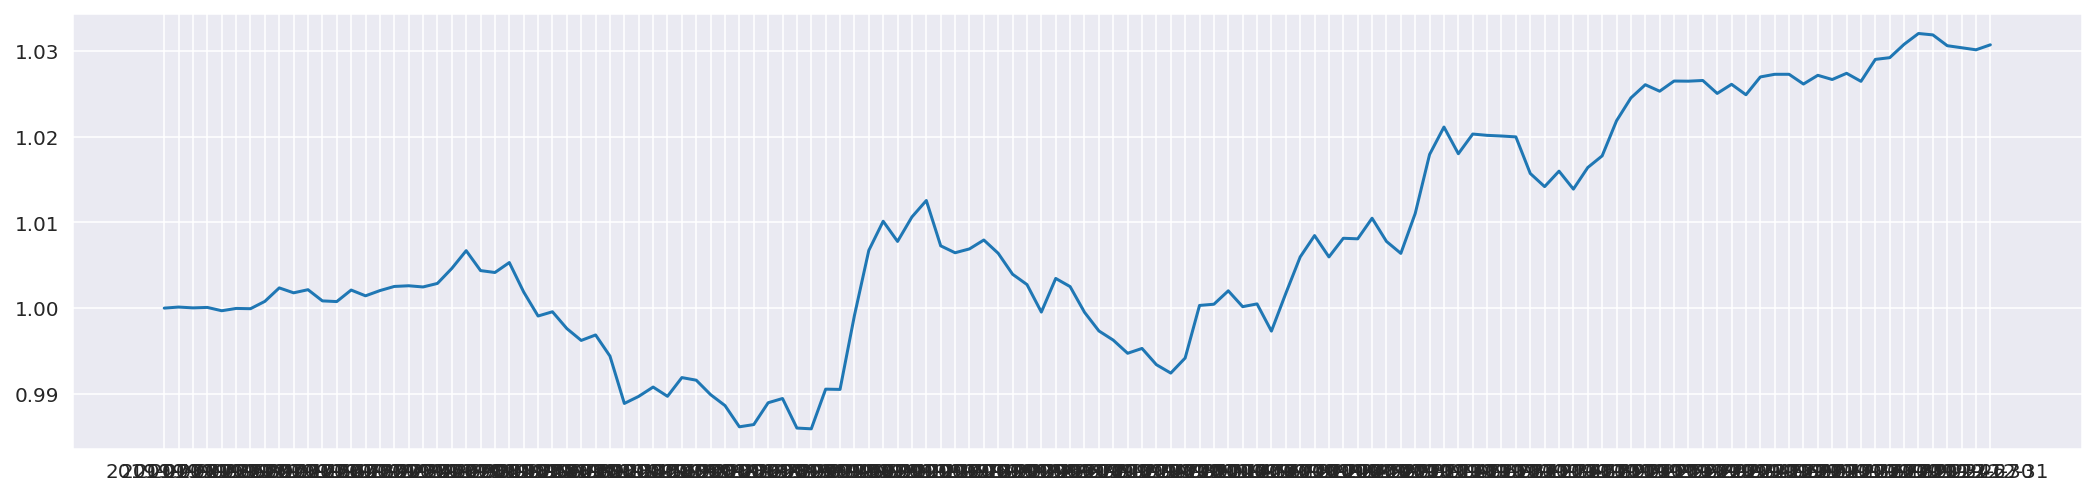

In [118]:
plt.figure(figsize=(18,4))
total_cumret = (1 + total_ret).cumprod()
plt.plot(total_cumret)

In [119]:
results_df.loc['G-c with WT'] = calculate_metrics(total_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Distance with WT (top10 pairs),0.078425,0.160259,2.302583,-0.029883,52.0
Simple Cointegration,-0.035992,-0.069623,-1.503482,-0.055507,111.0
Simple Cointegration (top10 pairs),-0.043637,-0.084093,-0.931237,-0.109663,111.0
Cointegration with WT,0.029183,0.058267,1.545514,-0.020241,34.0
Cointegration with WT (top10 pairs),0.082723,0.169381,2.300404,-0.033048,26.0
Simple G-c,-0.076815,-0.145598,-2.568052,-0.084236,118.0
G-c with WT,0.030703,0.061345,1.630954,-0.020634,34.0


In [120]:
# save returns and pairs df
pairs_dfs['granger_f'] = pairs_df
pair_rets['granger_f'] = pair_ret
traded_pairs['granger_f'] = pair_ret.columns

### Limit to top 10 pairs consisting of different stocks

In [121]:
selected_pairs = []
selected_stocks = []

# pairs opened on first trading days
for i in range(len(pair_cumret.index)):
    idx = pair_cumret.iloc[i][pair_cumret.iloc[i]!=1].index # pairs opened on day i
    # sort by Sharpe ratio and start selecting
    for pair in insample_sharpe.loc[idx].sort_values(by='Sharpe', ascending=False).index:
        s1,s2 = parse_pair(pair)
        if (s1 not in selected_stocks) and (s2 not in selected_stocks):
            selected_pairs.append(pair)
            selected_stocks.extend([s1,s2])
        if len(selected_pairs)==10:
            break
    if len(selected_pairs)==10:
            break

In [122]:
insample_sharpe.loc[selected_pairs]

,Sharpe
SYK-ROST,2.148488
ORCL-CME,2.078306
LOW-INFO,1.976852
BMY-GILD,1.936287
TMO-EW,1.853482
ABBV-PNC,1.814657
BLK-TEL,1.761865
PG-DUK,1.73713
MDT-EOG,1.642437
HON-LHX,1.641194


In [123]:
top_ret = pair_ret[selected_pairs].sum(axis=1) / len(selected_pairs)
top_cumret = (1 + top_ret).cumprod()

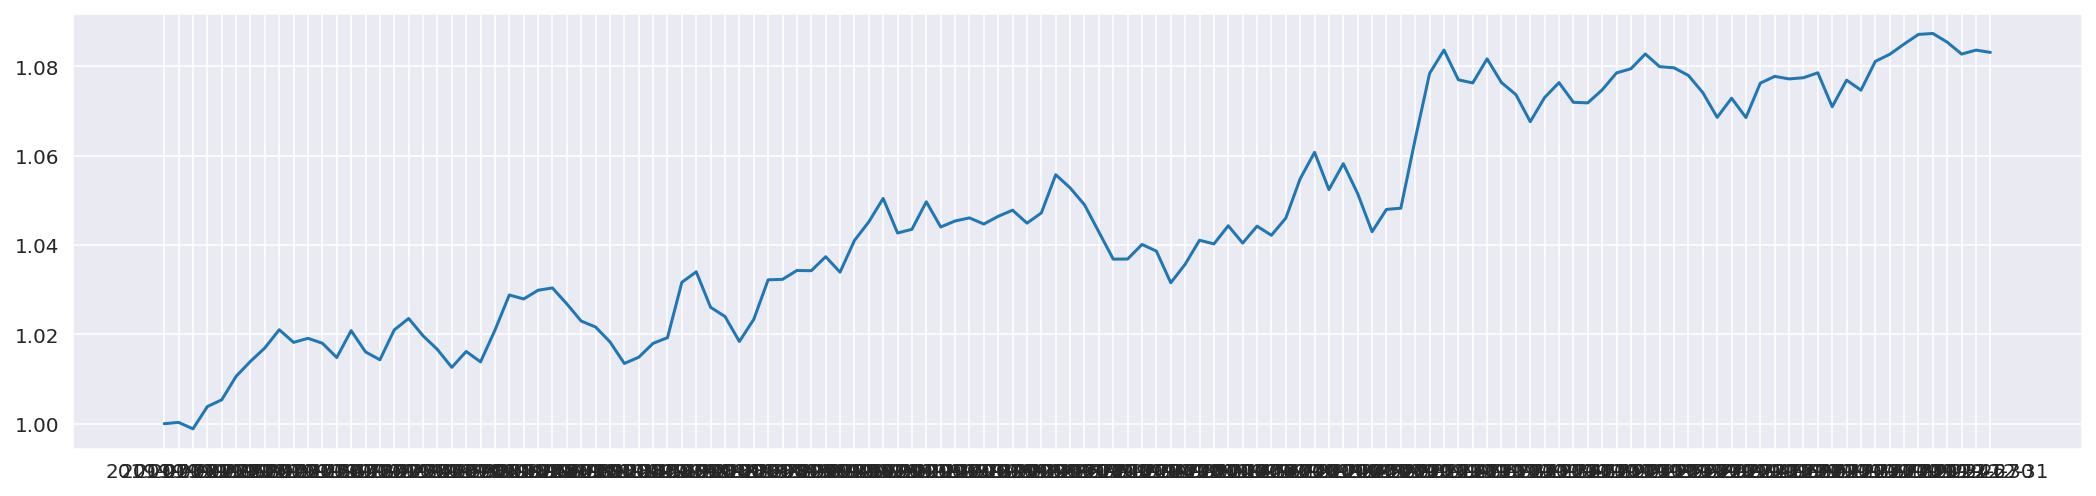

In [124]:
plt.figure(figsize=(18,4))
plt.plot(top_cumret)

In [125]:
results_df.loc['G-c with WT (top10 pairs)'] = calculate_metrics(top_cumret)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
Simple Distance,0.056689,0.114669,3.580566,-0.012320,23.0
Simple Distance (top10 pairs),0.082414,0.168725,2.343837,-0.022048,24.0
Distance with WT,0.048999,0.098755,3.080039,-0.011357,24.0
Distance with WT (top10 pairs),0.078425,0.160259,2.302583,-0.029883,52.0
Simple Cointegration,-0.035992,-0.069623,-1.503482,-0.055507,111.0
Simple Cointegration (top10 pairs),-0.043637,-0.084093,-0.931237,-0.109663,111.0
Cointegration with WT,0.029183,0.058267,1.545514,-0.020241,34.0
Cointegration with WT (top10 pairs),0.082723,0.169381,2.300404,-0.033048,26.0
Simple G-c,-0.076815,-0.145598,-2.568052,-0.084236,118.0
G-c with WT,0.030703,0.061345,1.630954,-0.020634,34.0
